In [1]:
import os 
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 


c:\projects\HumanEmotionsPred\HumanEmo\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\projects\HumanEmotionsPred\HumanEmo\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\projects\HumanEmotionsPred\HumanEmo\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the genc

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,Resizing,Rescaling,Layer,RandomContrast,RandomFlip,RandomRotation,RandomZoom,RandomCrop,InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,ModelCheckpoint,CSVLogger,TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPool2D,InputLayer,GlobalAveragePooling2D,Dropout,Activation,Add,Input
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy

In [3]:
train_dir = r"human-emotions-dataset\Emotions Dataset\Emotions Dataset\train"
val_dir = r"human-emotions-dataset\Emotions Dataset\Emotions Dataset\test"
CLASS_NAME = ["angry","happy","sad"]



In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAME,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
) 

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAME,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
) 

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


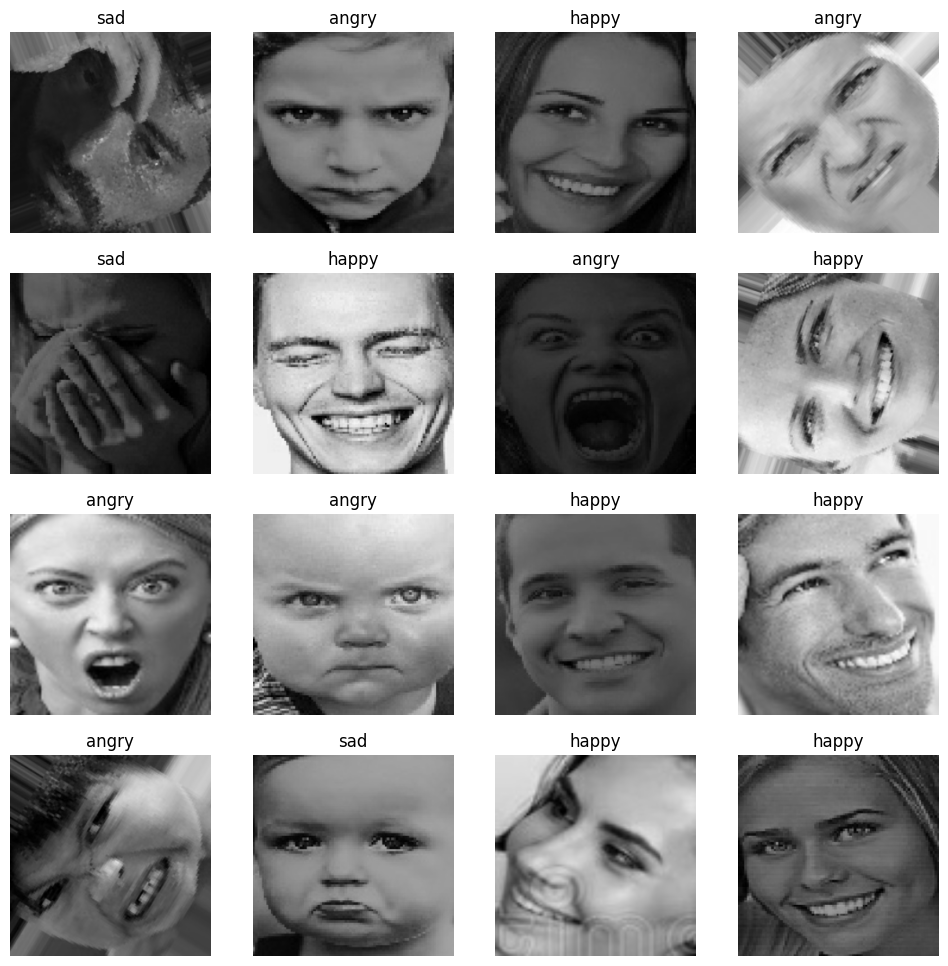

In [5]:
plt.figure(figsize=(12,12))
for image,label in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i]/255.0)

        plt.title(CLASS_NAME[tf.argmax(label[i],axis = 0).numpy()])
        plt.axis('off')

In [6]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)


In [7]:
CONFIGS = {
    "BATCH_SIZE":32,
    "IM_SIZE": 256,
    "N_FILTERS": 32,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS":20,
    "DROPOUT_RATE": 0.0,
    "KERNEL_SIZE": 3,
    "N_FILTERS": 6,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_UNITS_1": 100,
    "N_DENSE_UNITS_2": 10,
    "NUM_CLASSES": 3,
    "REGULARIZER_RATE": 0.001,
    "OPTIMIZER": Adam(learning_rate=0.001),
    "METRICS": ['accuracy']
}

### RESNET MODEL BUILDING

In [8]:
class CustomConv2D(Layer):
    def __init__(self,n_filters,kernel_size,n_strides,padding = 'valid'):
        super(CustomConv2D,self).__init__()
        self.conv = Conv2D(
            filters=n_filters,
            kernel_size=kernel_size,
            strides=n_strides,
            padding=padding,
            activation='relu'
        )

        self.batch_norm = BatchNormalization()


    def call(self,input):
        x = self.conv(input)
        x = self.batch_norm(x)
        return x

In [9]:
from tensorflow.keras.layers import MaxPooling2D

In [10]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)
    
    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training=training)

    return x
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
    
  def call(self, input, training):

    x = self.custom_conv_1(input, training=training)
    x = self.custom_conv_2(x, training=training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training=training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')
    
    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)
    
    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)
    
    self.conv_3_1 = ResidualBlock(128,2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256,2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)
    
    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGS["NUM_CLASSES"], activation = 'softmax')
    
  def call(self, x, training = True):
    x = self.conv_1(x,training=training)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training=training)
    x = self.conv_2_2(x, training=training)
    x = self.conv_2_3(x, training=training)
    
    x = self.conv_3_1(x, training=training)
    x = self.conv_3_2(x, training=training)
    x = self.conv_3_3(x, training=training)
    x = self.conv_3_4(x, training=training)
    
    x = self.conv_4_1(x, training=training)
    x = self.conv_4_2(x, training=training)
    x = self.conv_4_3(x, training=training)
    x = self.conv_4_4(x, training=training)
    x = self.conv_4_5(x, training=training)
    x = self.conv_4_6(x, training=training)
    
    x = self.conv_5_1(x, training=training)
    x = self.conv_5_2(x, training=training)
    x = self.conv_5_3(x, training=training)

    x = self.global_pool(x)
    
    return self.fc_3(x)

In [11]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]),training=True)
resnet_34.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)    │ ?                      │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       231,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       921,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     3,677,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     4,723,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     4,723,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 3)                 │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

#### MODEL CHECKPOINTING 

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath="best_weights.weights.h5",    
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True         
)

In [13]:
loss_func = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name ='accuracy'), TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]

In [14]:
resnet_34.compile(
    optimizer=Adam(learning_rate=CONFIGS["LEARNING_RATE"]),
    loss=loss_func,
    metrics=metrics
)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,ModelCheckpoint,CSVLogger,TensorBoard
earlystop = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)


reduced_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


In [16]:
# history = resnet_34.fit(
#     train_dataset,
    
#     validation_data=val_dataset,
#     epochs=CONFIGS["N_EPOCHS"]*3,
#     callbacks=[checkpoint_cb,earlystop,reduced_lr],
#     verbose=1
# )

In [17]:
# import pickle

# # Save
# with open("resnet34_history.pkl", "wb") as f:
#     pickle.dump(history.history, f)

In [18]:
# resnet_34.save("resnet_34.keras")

### Transfer learning with EfficientNet

In [19]:
for x, y in train_dataset.take(1):
    print(x.shape)  # should be (batch, H, W, 3)


(32, 256, 256, 3)


In [20]:
tf.__version__

'2.20.0'

In [21]:
from tensorflow.keras.applications import EfficientNetB4

TypeError: 'ResNet34' object is not subscriptable

In [22]:
for x, y in train_dataset.take(1):
    print(x.shape)  # should be (batch, H, W, 3)


(32, 256, 256, 3)


In [22]:
import efficientnet as ef
from efficientnet.tfkeras import EfficientNetB4
backbone = EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)

)

In [23]:
# backbone.summary()

In [24]:
##FreEZE thw weights
backbone.trainable = False

In [26]:
##MAKING THE REST OF CLASSIFIACTION MODEL

In [26]:
efficient_model = Sequential([
    Input(shape=(CONFIGS['IM_SIZE'],CONFIGS["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(units = 1024,activation='relu'),
    BatchNormalization(),
    Dense(units = 128,activation='relu'),
    Dense(units = 3,activation ='softmax')
])

efficient_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b4 (Functional)    │ (None, 8, 8, 1792)     │    17,673,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,836,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,645,531 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,864 (67.43 MB)

In [28]:
ef_model_loss_func = CategoricalCrossentropy()


In [29]:
ef_model_metrics = [CategoricalAccuracy(name = 'accuracy'),TopKCategoricalAccuracy(k=2,name = 'top 2 accuracy')]

In [30]:
efficient_model.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = ef_model_loss_func,
    metrics = ef_model_metrics
)

In [31]:
ef_model_checkpoint_cb = ModelCheckpoint(
    filepath="best_weights_eff_model.weights.h5",    
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True         
)

In [32]:
# ef_model_history = efficient_model.fit(train_dataset,
#                                        validation_data=val_dataset,
#                                        epochs = CONFIGS['N_EPOCHS'],
#                                        callbacks = [earlystop,reduced_lr,ef_model_checkpoint_cb])

In [33]:
# efficient_model.evaluate(val_dataset)

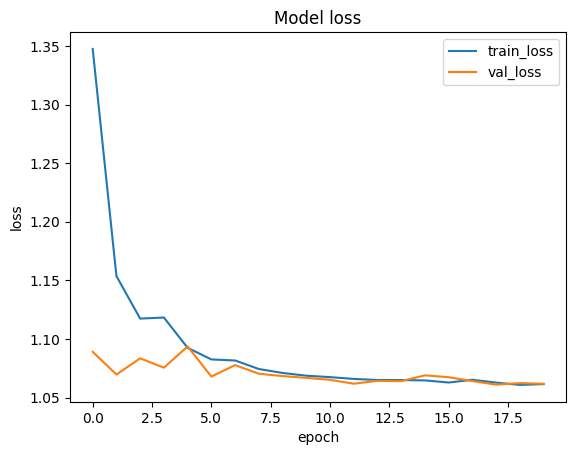

In [ ]:
plt.plot(ef_model_history.history['loss'])
plt.plot(ef_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])


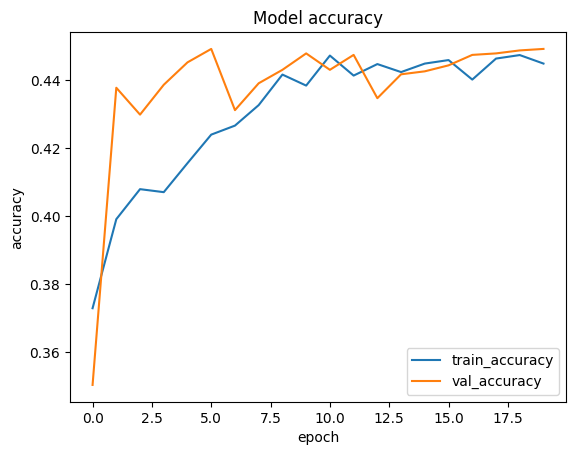

In [36]:
plt.plot(ef_model_history.history['accuracy'])
plt.plot(ef_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])